# Transformers

### In this lesson you'll learn:

- The core concepts behind the Transformer architecture
- How self-attention works 
- How to implement multi-head attention from scratch
- How to build positional encodings
- How to construct the complete Transformer (Encoder + Decoder)





In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import torch.optim as optim

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")



PyTorch version: 1.9.0


## 1. Understanding Self-Attention

Self-attention is the core mechanism that allows Transformers to model relationships between all positions in a sequence simultaneously. The attention mechanism can be summarized as:

$$
\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

Where:
- **Q** (Query): What we're looking for
- **K** (Key): What we're looking at  
- **V** (Value): The actual content we want to extract
- **d_k**: Dimension of the key vectors (for scaling)

Think of it like a search engine:
- **Query**: Your search terms
- **Key**: The keywords of each document
- **Value**: The actual content of each document
- **Attention weights**: How relevant each document is to your search

Try to implement the formula in the cell below



In [ ]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Scaled Dot-Product Attention

    Args:
        Q: Query matrix [batch_size, seq_len, d_k]
        K: Key matrix [batch_size, seq_len, d_k]
        V: Value matrix [batch_size, seq_len, d_v]
        mask: Optional mask to prevent attention to certain positions

    Returns:
        output: Attended values [batch_size, seq_len, d_v]
        attention_weights: Attention weights [batch_size, seq_len, seq_len]
    """

    # Get the dimension of keys for scaling
    d_k = Q.size(-1)

    # Step 1: Compute attention scores (Q * K^T)
    scores = ____________________

    print(f"Before scaling", scores)
    # Step 2: Scale by sqrt(d_k) to prevent softmax saturation
    # You can try without scaling and see the difference
    scores = _______________
    print(f"After scaling", scores)
    # Step 3: Apply mask if provided (set masked positions to large negative value)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # Step 4: Apply softmax to get attention weights
    attention_weights = _______________

    # Step 5: Apply attention weights to values
    output = torch.matmul(attention_weights, V)

    return output, attention_weights

# Test with a simple example
batch_size, seq_len, d_model = 1, 4, 8

# Create random Q, K, V matrices
Q = torch.randn(batch_size, seq_len, d_model)
K = torch.randn(batch_size, seq_len, d_model)
V = torch.randn(batch_size, seq_len, d_model)

output, attention_weights = scaled_dot_product_attention(Q, K, V)

print(f"Input shapes: Q{Q.shape}, K{K.shape}, V{V.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"\nAttention weights (should sum to 1 across last dimension):")
print(attention_weights[0])
print(f"Row sums: {attention_weights[0].sum(dim=-1)}")


Before scaling tensor([[[-5.8108, -3.6962, -4.3623, -8.6428],
         [-3.5381,  4.3192, -1.4130,  1.1963],
         [-3.0255, -1.0973, -1.4376,  1.4581],
         [-1.5793, -1.7662, -1.5380,  0.7021]]])
After scaling tensor([[[-2.0544, -1.3068, -1.5423, -3.0557],
         [-1.2509,  1.5271, -0.4996,  0.4229],
         [-1.0697, -0.3879, -0.5083,  0.5155],
         [-0.5584, -0.6244, -0.5437,  0.2482]]])
Input shapes: Qtorch.Size([1, 4, 8]), Ktorch.Size([1, 4, 8]), Vtorch.Size([1, 4, 8])
Output shape: torch.Size([1, 4, 8])
Attention weights shape: torch.Size([1, 4, 4])

Attention weights (should sum to 1 across last dimension):
tensor([[0.1942, 0.4102, 0.3242, 0.0714],
        [0.0408, 0.6555, 0.0864, 0.2173],
        [0.1041, 0.2057, 0.1824, 0.5078],
        [0.1926, 0.1803, 0.1955, 0.4316]])
Row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000])


<details>
<summary><strong>Solution:</strong></summary>

```python
scores = torch.matmul(Q, K.transpose(-2, -1))
scores = scores / math.sqrt(d_k)

attention_weights = F.softmax(scores, dim=-1)
```
</details>

###  Understanding Attention Weights

Let's visualize what the attention mechanism is actually doing. Complete the code below to create a heatmap of the attention weights:

How to read the heatmap:


*   Brighter cell at row i, column j means position i relien more on position j.
*   A bright diagonal means  tokens manily attend to local neighbors. Bright off-diagonals indicate long-rnage dependcies




Q: tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])
K: tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])
V:tensor([[[ 1.9269,  1.4873,  0.9007, -2.1055],
         [ 0.6784, -1.2345, -0.0431, -1.6047],
         [ 0.3559, -0.6866, -0.4934,  0.2415],
         [-1.1109,  0.0915, -2.3169, -0.2168],
         [-0.3097, -0.3957,  0.8034, -0.6216],
         [-0.5920, -0.0631, -0.8286,  0.3309]]])
Q: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 0.]]])
K: tensor([[[0., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.]]])


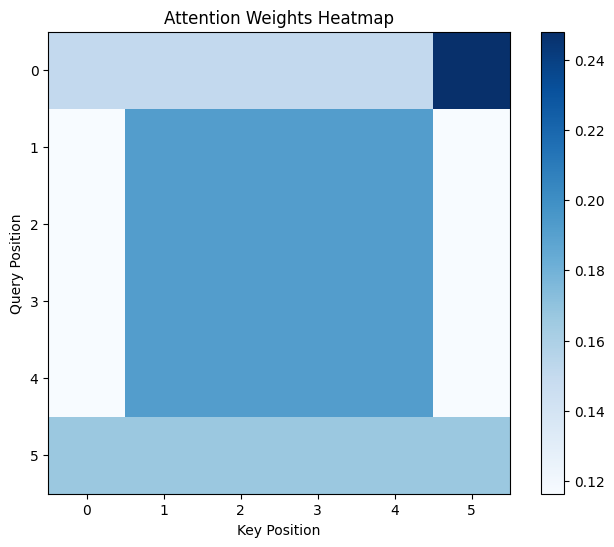

Attention weights matrix:
[[0.15  0.15  0.15  0.15  0.15  0.248]
 [0.116 0.192 0.192 0.192 0.192 0.116]
 [0.116 0.192 0.192 0.192 0.192 0.116]
 [0.116 0.192 0.192 0.192 0.192 0.116]
 [0.116 0.192 0.192 0.192 0.192 0.116]
 [0.167 0.167 0.167 0.167 0.167 0.167]]


In [ ]:
# Create a simple example with interpretable patterns
torch.manual_seed(42)

# Create Q, K, V where first position attends strongly to last position
seq_len = 6
d_model = 4

# Create patterns in Q and K that will create attention patterns
Q = torch.zeros(1, seq_len, d_model)
K = torch.zeros(1, seq_len, d_model)
V = torch.randn(1, seq_len, d_model)
print(f"Q: {Q}")
print(f"K: {K}")
print(f"V:{V}")
# Make first query similar to last key. In other words, make "first token" strongly looks at the last token
Q[0, 0, :] = torch.tensor([1.0, 0.0, 0.0, 0.0])
K[0, -1, :] = torch.tensor([1.0, 0.0, 0.0, 0.0])

# Make middle positions attend to themselves
for i in range(1, seq_len-1):
    Q[0, i, :] =_____________________
    K[0, i, :] =_____________________
print(f"Q: {Q}")
print(f"K: {K}")

# Fill in the missing code to compute attention and visualize
output, attention_weights = scaled_dot_product_attention(_____, ______, _____)

# Visualize attention weights
plt.figure(figsize=(8, 6))
plt.imshow(attention_weights[0].detach().numpy(), cmap='Blues')
plt.colorbar()
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Attention Weights Heatmap')
plt.show()

print("Attention weights matrix:")
print(attention_weights[0].detach().numpy().round(3))


<details>
<summary><strong>Solution:</strong></summary>

```python

for i in range(1, seq_len-1):
    Q[0, i, :] = torch.tensor([0.0, 1.0, 0.0, 0.0])
    K[0, i, :] = torch.tensor([0.0, 1.0, 0.0, 0.0])


output, attention_weights = scaled_dot_product_attention(Q, K, V)



```
</details>


## 2. Multi-Head Attention

While single-head attention is powerful, Multi-Head Attention allows the model to attend to different types of information simultaneously. Think of it as having multiple "attention experts" that each focus on different aspects of the input.

- Different representation subspaces: Each head can learn different types of relationships
- Increased model capacity: More parameters to learn complex patterns  
- Parallel processing: All heads can be computed simultaneously

The formula for multi-head attention is:

$$
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_h) W^O
$$

Where each head is:

$$
\text{head}_i = \mathrm{Attention}(Q W^Q_i, K W^K_i, V W^V_i)
$$


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        Multi-Head Attention Layer

        Args:
            d_model: Model dimension (must be divisible by num_heads)
            num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V and outout for all heads (computed in parallel)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        q_seq_len = query.size(1)
        k_seq_len = key.size(1)
        v_seq_len = value.size(1)

        # 1. Linear projections
        Q = ____________
        K = ____________
        V = ____________

        # 2. Reshape to separate heads: [batch_size, num_heads, seq_len, d_k]
        Q = ________________________________
        K = ________________________________
        V = ________________________________

        # 3. Apply attention to each head
        attention_output, attention_weights = _____________________

        # 4. Concatenate heads: [batch_size, q_seq_len, d_model]
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, q_seq_len, self.d_model
        )

        # 5. Apply output projection
        output = self.W_o(attention_output)

        return output, attention_weights

# Test the multi-head attention
d_model, num_heads = 512, 8
seq_len, batch_size = 10, 2

mha = MultiHeadAttention(d_model, num_heads)
x = torch.randn(batch_size, seq_len, d_model)

output, attention_weights = mha(x, x, x)  # Self-attention: Q=K=V=x

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"Number of parameters: {sum(p.numel() for p in mha.parameters())}")


Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Attention weights shape: torch.Size([2, 8, 10, 10])
Number of parameters: 1050624


<details>
<summary><strong>Solution:</strong></summary>

```python

Q = self.W_q(query)
K = self.W_k(key)  
V = self.W_v(value)


Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
attention_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

```
</details>

## Multi-Head Attention Parameters

Calculate how many parameters are in our Multi-Head Attention layer and understand where they come from.



In [ ]:
# Parameter calculation for Multi-Head Attention
d_model = 512
num_heads = 8

# Each linear layer has weight matrix [input_dim, output_dim] + bias [output_dim]


W_q_params = _______________________
W_k_params = _______________________
W_v_params = _______________________
W_o_params = _______________________

total_params = W_q_params + W_k_params + W_v_params + W_o_params

print(f"W_q parameters: {W_q_params:,}")
print(f"W_k parameters: {W_k_params:,}")
print(f"W_v parameters: {W_v_params:,}")
print(f"W_o parameters: {W_o_params:,}")
print(f"Total parameters: {total_params:,}")

# Verify with PyTorch
mha_test = MultiHeadAttention(d_model, num_heads)
pytorch_params = sum(p.numel() for p in mha_test.parameters())



W_q parameters: 262,656
W_k parameters: 262,656
W_v parameters: 262,656
W_o parameters: 262,656
Total parameters: 1,050,624


<details>
<summary><strong>Solution:</strong></summary>

```python
# Each linear layer has weight matrix [input_dim, output_dim] + bias [output_dim]
W_q_params = d_model * d_model + d_model  # 512*512 + 512 = 262,656
W_k_params = d_model * d_model + d_model  # 512*512 + 512 = 262,656
W_v_params = d_model * d_model + d_model  # 512*512 + 512 = 262,656
W_o_params = d_model * d_model + d_model  # 512*512 + 512 = 262,656
```

**Explanation**: Each of the 4 linear layers transforms from d_model (512) dimensions to d_model (512) dimensions, requiring 512×512 weight parameters plus 512 bias parameters each. In this implementation, the total number of parameters doens't depend on num of heads because splitting into heads is just a reshape.
</details>


## 3. Positional Encoding

One key limitation of the attention mechanism is that it has no inherent sense of position. Unlike RNNs that process sequences step by step, attention can access all positions simultaneously - but this means it doesn't know the order of elements!

**Example**: The sentences "The cat sat on the mat" and "The mat sat on the cat" would have identical attention computations without positional information.

### Solution: Positional Encoding

We add positional information to the input embeddings using sinusoidal functions:

$$
\mathrm{PE}(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$
$$
\mathrm{PE}(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

Where:
- `pos` is the position in the sequence
- `i` is the dimension index
- Even dimensions use sine, odd dimensions use cosine

As you would see in the Figure below, each position gets a unique pattern acroos dimensions.

Original input shape: torch.Size([2, 20, 512])
With positional encoding shape: torch.Size([2, 20, 512])
Positional encoding matrix shape: torch.Size([1, 100, 512])


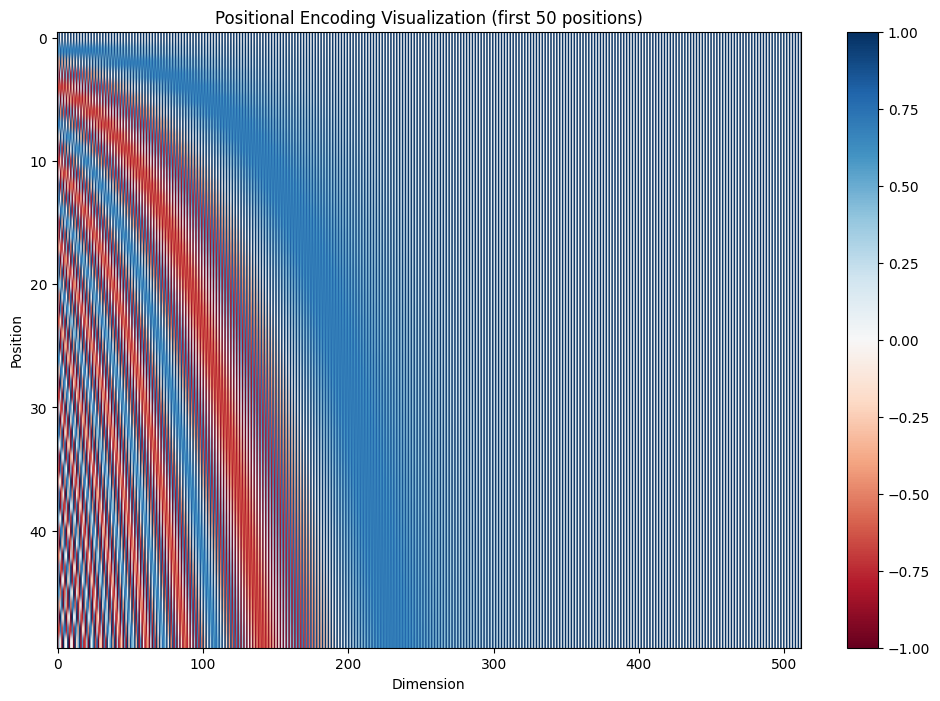

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000):
        """
        Sinusoidal Positional Encoding

        Args:
            d_model: Model dimension
            max_seq_len: Maximum sequence length to pre-compute
        """
        super(PositionalEncoding, self).__init__()

        # Allocate "pe" of shape [max_seq_len, d_model] filled with zero
        pe = __________________
        # Build position as [max_seq_len, 1] containing 0,1,2,.... for broadcasting
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()

        # Create the div_term for the sinusoidal pattern
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(math.log(10000.0) / d_model))

        # Fill even and odd dimensions (you can use torch.sin and torch.cos)
        pe[:, 0::2] = ___________________

        pe[:, 1::2] = _____________________

        # Add batch dimension and register as buffer (not a parameter)
        pe = pe.unsqueeze(0)  # [1, max_seq_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Add positional encoding to input embeddings

        Args:
            x: Input embeddings [batch_size, seq_len, d_model]
        Returns:
            x + positional encodings
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

# Test positional encoding
d_model = 512
max_seq_len = 100

pos_enc = PositionalEncoding(d_model, max_seq_len)

# Create dummy input
batch_size, seq_len = 2, 20
x = torch.randn(batch_size, seq_len, d_model)

# Add positional encoding
x_with_pos = pos_enc(x)

print(f"Original input shape: {x.shape}")
print(f"With positional encoding shape: {x_with_pos.shape}")
print(f"Positional encoding matrix shape: {pos_enc.pe.shape}")

# Visualize positional encodings
plt.figure(figsize=(12, 8))
plt.imshow(pos_enc.pe[0, :50, :].numpy(), cmap='RdBu', aspect='auto')
plt.colorbar()
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.title('Positional Encoding Visualization (first 50 positions)')
plt.show()


<details>
<summary><strong>Solution:</strong></summary>

```python
pe = torch.zeros(max_seq_len, d_model)

# Apply sine to odd indices
pe[:, 0::2] = torch.sin(position * div_term)
# Apply cosine to odd indices  
pe[:, 1::2] = torch.cos(position * div_term)
```
</details>


## 4. Feed-Forward Network

Each Transformer layer also includes a position-wise feed-forward network that processes each position independently. It's a simple two-layer MLP with ReLU activation:


$$
\mathrm{FFN}{x} = \max(0,\, xW_1 + b_1)\, W_2 + b_2
$$

This adds non-linearity and allows the model to transform the attention outputs.


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        Position-wise Feed-Forward Network

        Args:
            d_model: Model dimension
            d_ff: Hidden dimension of feed-forward layer (usually 4 * d_model)
            dropout: Dropout rate
        """
        super(FeedForward, self).__init__()

        self.linear1 = _______________________
        self.linear2 = _______________________
        self.dropout = _______________________

    def forward(self, x):

        return ___________________________

# Test feed-forward network
d_model = 512
d_ff = 2048  # Typically 4 * d_model

ff = FeedForward(d_model, d_ff)
x = torch.randn(2, 20, d_model)
output = ff(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Feed-forward parameters: {sum(p.numel() for p in ff.parameters()):,}")

# The parameters come from two linear layers:
# Linear1: d_model * d_ff + d_ff = 512 * 2048 + 2048 = 1,050,624
# Linear2: d_ff * d_model + d_model = 2048 * 512 + 512 = 1,049,088
# Total: 2,099,712


Input shape: torch.Size([2, 20, 512])
Output shape: torch.Size([2, 20, 512])
Feed-forward parameters: 2,099,712


<details>
<summary><strong>Solution:</strong></summary>

```python
self.linear1 = nn.Linear(d_model, d_ff)
self.linear2 = nn.Linear(d_ff, d_model)
self.dropout = nn.Dropout(dropout)
def forward(self, x):
  return self.linear2(self.dropout(F.relu(self.linear1(x))))


```
</details>

## 5. Transformer Encoder Layer

Now we can combine all components into a complete Transformer Encoder Layer. Each layer consists of:

1. Multi-Head Self-Attention
2. Residual connection (original input) + Layer Normalization
3. Feed-Forward Network
4. Residual connection + Layer Normalization

The residual connections help with gradient flow, and layer normalization stabilizes training.


In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Single Transformer Encoder Layer

        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward hidden dimension
            dropout: Dropout rate
        """
        super(TransformerEncoderLayer, self).__init__()


        self.multi_head_attention = ______________
        self.feed_forward = _____________________
        self.dropout = ____________
        # Layer normalization
        self.norm1 = _____________
        self.norm2 = __________



    def forward(self, x, mask=None):
        # define the forward function
        # First step is attention mechanism
        # Second step is adding and normalizing the attention output
        # Third step is passing the output from the previous step through the feed forward network
        # Fourth step is adding and anormalziing the output from the previous step


        return x

# Test encoder layer
d_model, num_heads, d_ff = 512, 8, 2048
encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff)

x = torch.randn(2, 20, d_model)
output = encoder_layer(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Encoder layer parameters: {sum(p.numel() for p in encoder_layer.parameters()):,}")


Input shape: torch.Size([2, 20, 512])
Output shape: torch.Size([2, 20, 512])
Encoder layer parameters: 3,152,384


<details>
<summary><strong>Solution:</strong></summary>

```python


self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
self.feed_forward = FeedForward(d_model, d_ff, dropout)
self.norm1 = nn.LayerNorm(d_model)
self.norm2 = nn.LayerNorm(d_model)
self.dropout = nn.Dropout(dropout)



        
def forward(self, x, mask=None):

    # Multi-head attention with residual connection and layer norm
    attn_output, _ = self.multi_head_attention(x, x, x, mask)
    x = self.norm1(x + self.dropout(attn_output))
    
    # Feed-forward with residual connection and layer norm
    ff_output = self.feed_forward(x)
    x = self.norm2(x + self.dropout(ff_output))
    
    return x


```
</details>

## 6. Transformer Decoder Layer

The decoder turns partial target sequences into the next-token predictions, one layer at a time. each layer takes the current target states x (embeddings plus positional encodings) and the encoder's output, then refines x through three sublayers with residual connection and LayerNorm.
First, masked sekf-attention lets each target position attend only to earlier or current target positions (a casual mask blocks the future). This produces context-aware states while preserving autoregressive order.
Second, cross attention lets those states query the encoder output so the the decoder can align with and extact information from the source sequence.
Third, a position wise feed-forward network transforms each position to increase represententaional power.
After each sublayer, a residual connection and LayerNorm stabilize training:dropout helps regularize.



In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
      # Initialize the layers (multi-head attenton, cross-attention, feed forward, 3 layer normalization and dropout)












    def forward(self, x, encoder_output, src_mask, tgt_mask):
















        return x


<details>
<summary><strong>Solution:</strong></summary>

```python


class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Transformer Decoder Layer
        
        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward hidden dimension
            dropout: Dropout rate
        """
        super(TransformerDecoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.cross_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        """
        Forward pass through decoder layer
        
        """
        attn_output, _ = self.multi_head_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output, _ = self.cross_attention(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x


```
</details>

## 8. Completing Transformer Structure
Now we'll put every components (Embeddings, positionale encoding,encoder layers and decoder layetrs) together. Finally, we will have built the structure from the original paper. ("Attention is all you need", 2017)


<center><img src="/nfs/home/myuecel3/intro_pharma_ai/Notebooks_EN/Img/transformer/transfomer_structure.png"></center>
<h8><center> Source: Attention is all you need, 2017</center></h8>
</center>

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        """
        Complete Transformer model

        Args:
            d_model: Model dimension
            num_heads: Number of attention heads
            d_ff: Feed-forward hidden dimension
            num_layers: Number of encoder/decoder layers
            vocab_size: Size of vocabulary
            max_seq_len: Maximum sequence length
            dropout: Dropout rate
        """
        super(Transformer, self).__init__()
        self.encoder_embeddings = nn.Embedding(_______,______) #Embedd the source information
        self.decoder_embeddings = nn.Embedding(______,______) # Embed the target
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)
        self.encoder_layers = nn.ModuleList(______________________________________________)
        self.decoder_layers = nn.ModuleList(______________________________________________)
        self.linear = nn.Linear(d_model, tgt_vocab_size)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)


    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.pos_encoding(_________________))
        tgt_embedded = self.dropout(self.pos_encoding(__________________))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            ______________ = _______________________

        output = self.linear(____________)
        return output


<details>
<summary><strong>Solution:</strong></summary>

```python

self.encoder_embeddings = nn.Embedding(src_vocab_size,d_model) #Embedd the source information
self.decoder_embeddings = nn.Embedding(tgt_vocab_size,d_model) # Embed the target
self.pos_encoding = PositionalEncoding(d_model, max_seq_len)
self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
self.decoder_layers = nn.ModuleList([TransformerDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
self.linear = nn.Linear(d_model, tgt_vocab_size)
self.softmax = nn.Softmax(dim=-1)
self.dropout = nn.Dropout(dropout)


def forward(self, src, tgt):
    src_mask, tgt_mask = self.generate_mask(src, tgt)
    src_embedded = self.dropout(self.pos_encoding(self.encoder_embeddings(src)))
    tgt_embedded = self.dropout(self.pos_encoding(self.decoder_embeddings(tgt)))

    enc_output = src_embedded
    for enc_layer in self.encoder_layers:
        enc_output = enc_layer(enc_output, src_mask)

    dec_output = tgt_embedded
    for dec_layer in self.decoder_layers:
        dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

    output = self.linear(dec_output)
    return output


```
</details>

## Traning the transformer
Just for demonstration purposes, we'll create a random data points and train the transformer with it. 

In [ ]:

src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(5): # Just for demonstration purposes
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.675379753112793
Epoch: 2, Loss: 8.551066398620605
Epoch: 3, Loss: 8.489352226257324
Epoch: 4, Loss: 8.433281898498535
Epoch: 5, Loss: 8.384696006774902


In [ ]:
transformer.eval()

# Generate random sample validation data
val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))

with torch.no_grad():

    val_output = transformer(val_src_data, val_tgt_data[:, :-1])
    val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    print(f"Validation Loss: {val_loss.item()}")

Validation Loss: 8.668462753295898


Further Reading
- The Illustrated Transformer, https://jalammar.github.io/illustrated-transformer/
- Transformers from scratch, https://e2eml.school/transformers.html
- Attention is all you need, https://doi.org/10.48550/arXiv.1706.03762
- Transformer Model Tutorial in PyTorch: From Theory to Code, https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch